# Analysis of equal chromaticity RCS lattice from Jeffrey Eldred

**April 25, 2018**

This notebook is designed for doing analysis of Jeff's simulatons.


**April 05, 2018**

This version now seems to run properly with Jeff's RCS chrome v3 lattice (could also use chrome v2). I've been able to do a quick simulation with a properly matched KV bunch and I see very good behavior. What I need to do is the following:

1. Verify the chromaticity
2. Simulate bunches with different energy spread
3. Look at how the invariants change with energy spread
4. Evaluate the dynamic aperture with small delta_p.
5. Begin to evaluate Stephen's map approach with this lattice.

## Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy import constants
import tables
from mpi4py import MPI

In [3]:
from rssynergia.base_diagnostics import utils
from rssynergia.base_diagnostics import read_bunch
from rssynergia.base_diagnostics import workflow
from rssynergia.base_diagnostics import lfplot
from rssynergia.base_diagnostics import latticework
from rssynergia.base_diagnostics import basic_calcs
from rssynergia.base_diagnostics import pltbunch
from rssynergia.base_diagnostics import elliptic_sp
from rssynergia.base_diagnostics import singleparticle
from rssynergia.base_diagnostics import options
from rssynergia.base_diagnostics import diagplot
from rssynergia.standard import standard_beam6d
from rssynergia.elliptic import elliptic_beam6d
from rssynergia.semigaussian import semi_gaussian6d
import synergia
import synergia_workflow

## Load options and lattice

In [4]:
#load options for ZC_test
from ZC_test_options import opts

#================== Setting up logger and MPI comunicator ============================
#try:
#if True:
# this is the communicator object that will be used for MPI operations
comm = synergia.utils.Commxx()
myrank = comm.get_rank()
mpisize = comm.get_size()
verbose = opts.verbosity>0

logger = synergia.utils.Logger(0)


if myrank == 0:
    print "my rank is 0"
else:
    print "not rank 0"

my rank is 0


In [5]:
#================== Load the lattice =======================

lattices = {}
dir_66 = '/Users/ncook/radiasoft/ioptics/ioptics/lattices/Iota6-6/'
dir_82 = '/Users/ncook/radiasoft/ioptics/ioptics/lattices/Iota8-2/'
#lattices['t1_1IO_66'] = dir_66 + "lattice_1IO_center.madx" #centered t1 6.6 1IO lattice
#lattices['t3_1IO_66'] = dir_66 + "lattice_1IO_nll_center.madx" #centered t3 6.6 1IO lattice

#lattices['new_t1_chrom'] = 'lattice_t1_1IO_eqChrom-9.madx'
dir_RCS = '/home/vagrant/jupyter/RCS_chrome/'


lattices['RCSv2-t1_dQ00'] = dir_RCS +'RCSv2io_mn_dQ00_nmat.madx'
lattices['RCSv2-t3_dQ00'] = dir_RCS +'RCSv2io_nl_dQ00_nmat.madx'
lattices['RCSv3-t3_dQ00'] = dir_RCS +'RCSv3_nl_dQ00.seq' #'RCSv3_nl_dQ00.madx'
lattices['RCSv3-t1_dQ00'] = dir_RCS +'RCSv3_mn_dQ00.madx'
lattices['chromev2_RCSv3'] = dir_RCS +'RCSv3_nl_dQ00_chrom_2_DCELL.madx'
lattices['chromev3_RCSv3'] = dir_RCS +'RCSv3_nl_dQ00_chrom_3_DCELL.madx'


#================= Construct a Python dictionary of lattice stuff ==================
lattice_dict = {}

for keys in lattices.keys():
    lattice_dict[keys] = {} #instantiate sub dictionary
    lattice_dict[keys]['name'] = keys
    lattice_dict[keys]['location'] = lattices[keys]
    lattice_dict[keys]['lattice'] = synergia.lattice.MadX_reader().get_lattice("dcell", lattices[keys])

In [6]:
#define reference particle using t1 lattice
ref_key = 'RCSv3-t1_dQ00'
reference_particle = lattice_dict[ref_key]['lattice'].get_reference_particle()
energy = reference_particle.get_total_energy()
opts.beta = reference_particle.get_beta()
opts.gamma = reference_particle.get_gamma()


#================== Setting up the options =======================

n_ppc = 10
nsteps_per_element = 4

opts.gridx = 32
opts.gridy = 32
opts.gridz = 1

n_macro = n_ppc*opts.gridx*opts.gridy
name = 'v3_Chrome'
outputdir = "t3_RCS"

nsteps = len(lattice_dict[ref_key]['lattice'].get_elements())*nsteps_per_element
opts.output_dir = outputdir
opts.relpath = opts.output_dir
opts.macro_particles = n_macro
opts.steps = nsteps
opts.steps_per_element = nsteps_per_element
workflow.make_path(outputdir)

print "output directory:", opts.output_dir


#==================== Set up space charge solver ==========================

#turn off space charge
requested_stepper = opts.stepper
opts.requested_stepper = requested_stepper
if opts.spacecharge:
    
    solver = opts.solver
    # space charge only works with the split operator stepper, or soelements 
    if (requested_stepper != "splitoperator") and (requested_stepper != "soelements"):
        requested_stepper = "soelements"
        print "Requested stepper changed to soelements for space charge"

    #force these
    gridx = 32
    gridy = 32
    gridz = 1
    grid = [opts.gridx, opts.gridy, opts.gridz]

    print >>logger, "grid: ", grid

    #opts.comm_divide = None
    if opts.comm_divide:
        sc_comm = synergia.utils.Commxx_divider(opts.comm_divide, False)
    else:
        sc_comm = synergia.utils.Commxx(True)

    #sc_comm = synergia.utils.Commxx(True)
    if solver == "2dopen-hockney":
        coll_operator = synergia.collective.Space_charge_2d_open_hockney(sc_comm, grid)
    elif solver == "3dopen-hockney":
        # full signature for 3d_open_hockney constructor is
        # comm, grid, long_kicks, z_periodic, period, grid_entire_period,nsigma
        coll_operator = synergia.collective.Space_charge_3d_open_hockney(sc_comm, grid, opts.long_kicks, False, 0.0, False, opts.nsigma)
    elif solver == "2dbassetti-erskine":
        coll_operator = synergia.collective.Space_charge_2d_bassetti_erskine()
    else:
        raise RuntimeError, "requested space charge operator %s invalid.  Must be either 2dopen-hockney or 3dopen-hockney"%opts.solver

    print "Using space charge solver ", solver
    print "Grid: ", gridx, " x ", gridy, " x ", gridz

else:
    coll_operator = synergia.simulation.Dummy_collective_operator("stub")
    print "No space charge solver used"

#now set element type and construct stepper
print "use maps for: {}".format(opts.use_maps)
print "requested_stepper: {}".format(requested_stepper)

output directory: t3_RCS
No space charge solver used
use maps for: none
requested_stepper: splitoperator


In [7]:
#================== Setting up the stepper and lattice simulator =======================

for key in lattices.keys():
    
    current_lattice = lattice_dict[key]['lattice']
    
    
    nsteps = len(current_lattice.get_elements())*nsteps_per_element
    opts.steps = nsteps
    
    for elem in current_lattice.get_elements():
        #if elem.get_name() == "nlr1" or elem.get_name() == "nlr2":
        #    elem.set_string_attribute('no_simplify', 'true')
        #    elem.set_string_attribute('force_diagnostics', 'true')
        
        if elem.get_name() == "sd1r" or elem.get_name() == "sd1l":
            elem.set_string_attribute('no_simplify', 'true')
            elem.set_string_attribute('force_diagnostics', 'true')        
        
        
        if elem.get_type() == "nllens" or elem.get_type() == "sextupole":
            elem.set_string_attribute("extractor_type", "chef_propagate")
            #elem.set_string_attribute('no_simplify', 'true')
            #elem.set_string_attribute('force_diagnostics', 'true')
        
        
        #set chef propagation for ALL elements
        #elem.set_string_attribute("extractor_type", "chef_propagate")
            
    lattice_dict[key]['stepper'] = latticework.generate_stepper(current_lattice,coll_operator, opts)
    lattice_dict[key]['lattice_simulator'] = lattice_dict[key]['stepper'].get_lattice_simulator()

Using split-operator stepper with  600  steps/turn
Using split-operator stepper with  600  steps/turn
Using split-operator stepper with  420  steps/turn
Using split-operator stepper with  420  steps/turn
Using split-operator stepper with  420  steps/turn
Using split-operator stepper with  424  steps/turn


## Select the lattice for analysis

I also plot the lattice functions to make it clear what lattice is being used for analysis.

We also need to specify the nonlinear element parameters for our chosen lattice.

/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


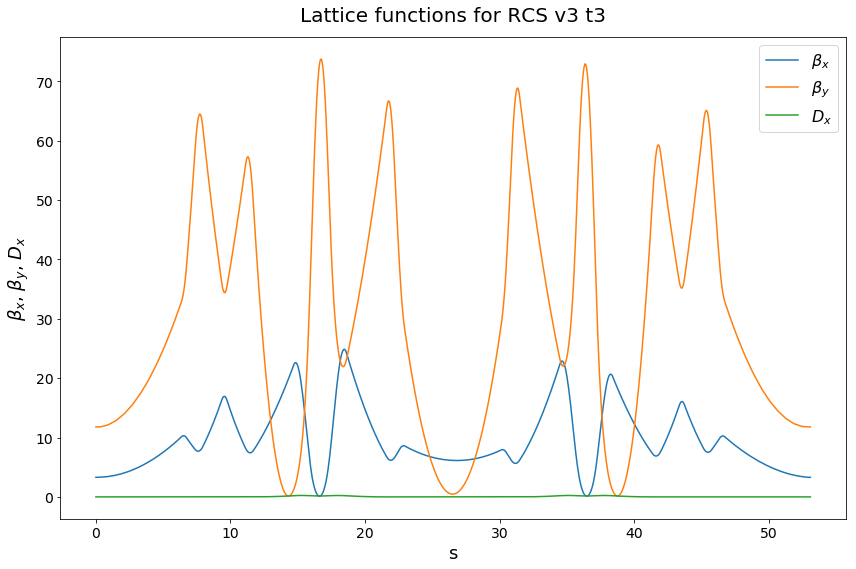

In [8]:
sim_key = 'chromev3_RCSv3'

opts.lattice = lattice_dict[sim_key]['lattice']
opts.lattice_simulator = lattice_dict[sim_key]['lattice_simulator']
opts.stepper = lattice_dict[sim_key]['stepper']

opts.save = False #True
opts.lattice_name = 'RCS v3 t3'
opts.lf_fns = ['beta_x','beta_y','D_x']
lfplot.plot_sliced_lattice_functions(opts)

#Now compute the necessary Twiss parameters at the center of the nonlinear element
mu0chrome3= 0.2990076
NL2 = 6.36303384
mu0 = 0.3
cval = 0.03
tval = 0.4

opts.t = tval
opts.c = 0.03
opts.lnll = 2.*NL2
opts.new_tune = mu0chrome3
vals = basic_calcs.get_base_nll(opts.lnll, opts.new_tune, opts.t, opts.c)

opts.betae = vals[0]
opts.alphae = 0
opts.beta0 = vals[-1]

## Analysis - demonstrating rssynergia built-in functions

You need to enter the following here:

1. output directory
2. number of turns

In [9]:
outputdir = 't3_RCS_chrom3'
opts.output_dir = outputdir
opts.turns = 256 

You can produce Poincare plots quickly to look at particle orbits

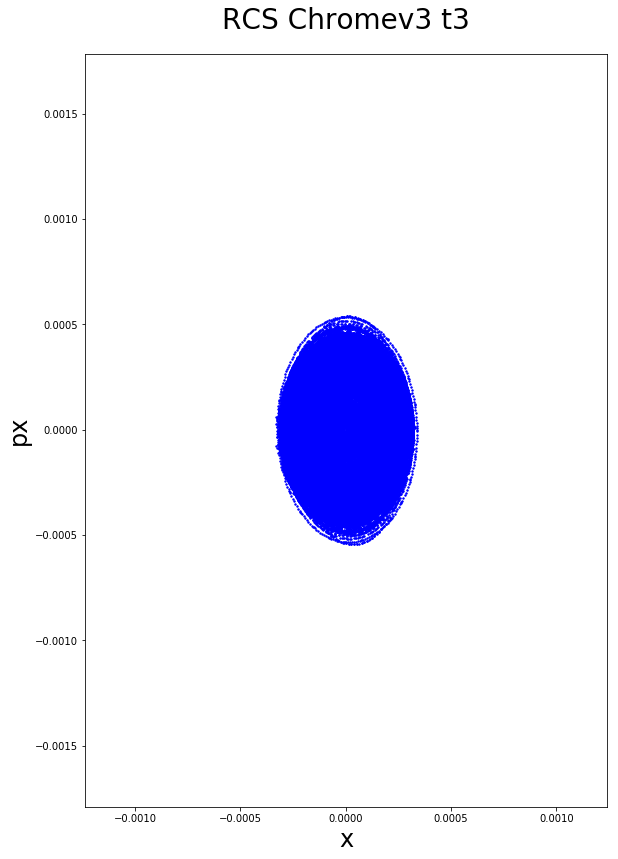

In [10]:
opts.relpath = opts.output_dir
opts.plots = ['x','px']
opts.plot_lost = False
opts.lost = False
opts.num = 500
opts.scale = 2
opts.lattice_name = 'RCS Chromev3 t3'
opts.save = False

elliptic_sp.toy_plot_Poincare(opts)

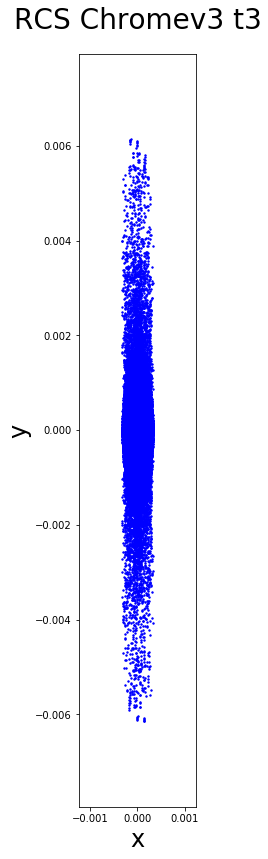

In [11]:
opts.relpath = opts.output_dir
opts.plots = ['x','y']
opts.plot_lost = False
opts.lost = True
opts.num = 500
opts.scale = 2
opts.save = False
elliptic_sp.toy_plot_Poincare(opts)

You can also plot the invariants for a given particle

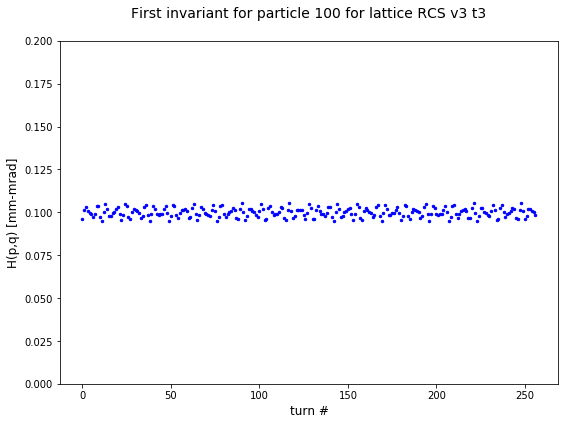

In [12]:
opts.relpath = opts.output_dir
opts.plots = ['x','px']
opts.range = None
opts.plot_lost = False
opts.lost = True
opts.num = 1
opts.scale = 2
opts.ID = 100
opts.norm = False
opts.variance = 1
opts.lattice_name = 'RCS v3 t3'
opts.save = False
elliptic_sp.toy_plot_elliptic_invariant(opts)

## Compute the invariants over the length of the simulation

This is likely more useful for you.

In [13]:
files = elliptic_sp.get_file_list(opts)
twiss = elliptic_sp.get_toy_twiss(opts)
lostlist = elliptic_sp.get_lost_particle_list(opts)
lost = lostlist.any()

hArray = []
iArray = []
dppArray = []

opts.lost = False

for index,outfile in enumerate(files):
    if index%20 == 0:
        print "Calculating invariants for file {}".format(index)
    
    if lost.any():
        header, particles, lost_particles = elliptic_sp.get_particles(outfile, lost, lostlist)
    else:
        header, particles = elliptic_sp.get_particles(outfile, lost)
    
    #grab invariants for that file
    hVals, iVals = elliptic_sp.toy_calc_bunch_H(particles, opts, elliptic=True)
    
    #grab the momentum coordinates (deltap/p)
    dppVals = particles[:,5]
    
    if hArray == []:   #handle base case
        hArray = np.asarray(hVals)
        iArray = np.asarray(iVals)
        dppArray = np.asarray(dppVals)
    else:
        hArray = np.vstack((hArray,np.asarray(hVals)))
        iArray = np.vstack((iArray,np.asarray(iVals)))
        dppArray = np.vstack((dppArray,np.asarray(dppVals)))

Calculating invariants for file 0
Calculating invariants for file 20


/home/vagrant/.pyenv/versions/2.7.14/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Calculating invariants for file 40
Calculating invariants for file 60
Calculating invariants for file 80
Calculating invariants for file 100
Calculating invariants for file 120
Calculating invariants for file 140
Calculating invariants for file 160
Calculating invariants for file 180
Calculating invariants for file 200
Calculating invariants for file 220
Calculating invariants for file 240


Plotting values for a given particle involves slicing the appropriate array:

- hArray[0,:] gives the distribution of H values for the bunch at turn 0
- hArray[:,0] gives the evolution of H values for particle 0 for all turns

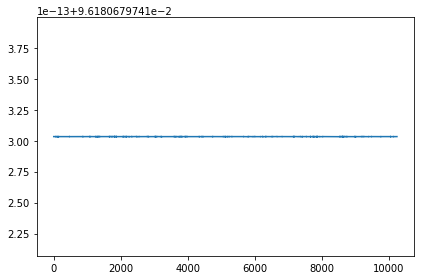

In [43]:
plt.plot(hArray[0,:]/1e-6)

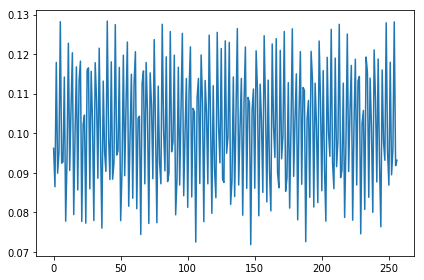

In [15]:
plt.plot(hArray[:,0]/1e-6)

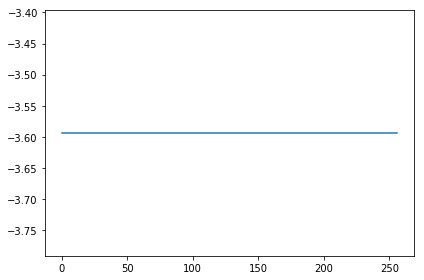

In [16]:
plt.plot(dppArray[:,0]*1e3)